<h1> InputDataSet Class and sktime example </h1>
First we import packages and check we have access to the GPU.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.deep_learning.resnet import ResNetClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2


from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-04-12 18:11:13.507147: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 18:11:13.529166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:11:13.529186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:11:13.529844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 18:11:13.533434: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


2024-04-12 18:11:14.843331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:11:14.847271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:11:14.847366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<h2> Define functions </h2>
A function to asses the models we train.

In [2]:
# def asses_model(model_name, y_pred, y_test):
#     print()
#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     kappa = cohen_kappa_score(y_pred, y_test)

#     # Print accuracy and Cohen Kappa score with explanations
#     print(f'Accuracy of {model_name}: {accuracy:.4f}')
#     # Cohen Kappa Score measures the agreement between the predicted and actual labels adjusted for chance.
#     print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

#     # Calculate and sort the normalized predicted label count
#     unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
#     unique_test, counts_test = np.unique(y_test, return_counts=True)
#     normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
#     # Sort by the number of predictions
#     sorted_keys = sorted(normalized_counts_pred, key=normalized_counts_pred.get, reverse=True)
#     sorted_values = [normalized_counts_pred[k] - 1 for k in sorted_keys]

#     # Plotting the percent the model over or under predicted the labels
#     plt.figure(figsize=(2*unique_pred.shape[0], 4))
#     bars = plt.bar(sorted_keys, sorted_values, color=['green' if x > 0 else 'Blue' for x in sorted_values])
#     plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
#     plt.xlabel('Labels')
#     plt.ylabel('Percent Over/Under Prediction')
    
#     # Center y-axis and set equal extension above and below
#     max_extent = max(abs(min(sorted_values)), abs(max(sorted_values)))* 1.05
#     plt.ylim(-max_extent, max_extent)
#     plt.axhline(y=0, color='gray', linewidth=0.8)  # Add line at y=0
#     plt.show()

#     # Display confusion matrices sorted by frequency of the prediction
#     fig, axes = plt.subplots(1, 3, figsize=(24, 8))
#     sorted_labels = sorted(unique_pred, key=lambda x: -counts_pred[np.where(unique_pred == x)[0][0]])
#     for i, norm in enumerate([None, 'true', 'pred']):
#         ax = axes[i]
#         ConfusionMatrixDisplay.from_predictions(
#             y_test, y_pred, normalize=norm, ax=ax,
#             xticks_rotation='vertical', labels=sorted_labels
#         )
#         ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')

#     plt.tight_layout()
#     plt.show()
    
# def asses_model(model_name, y_pred, y_test, labels_order):
#     print()
#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     kappa = cohen_kappa_score(y_pred, y_test)

#     # Print accuracy and Cohen Kappa score with explanations
#     print(f'Accuracy of {model_name}: {accuracy:.4f}')
#     print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

#     # Calculate the normalized predicted label count
#     unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
#     unique_test, counts_test = np.unique(y_test, return_counts=True)
#     normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
#     # Calculate the percent the model over or under predicted the labels using the specified label order
#     sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

#     # Plotting the percent the model over or under predicted the labels
#     plt.figure(figsize=(2*len(labels_order), 4))
#     plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
#     plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
#     plt.xlabel('Labels')
#     plt.ylabel('Percent Over/Under Prediction')
    
#     # Center y-axis and set equal extension above and below
#     max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
#     plt.ylim(-max_extent, max_extent)
#     plt.axhline(y=0, color='gray', linewidth=0.8)
#     plt.show()

#     # Display confusion matrices using the specified label order
#     fig, axes = plt.subplots(1, 3, figsize=(24, 8))
#     for i, norm in enumerate([None, 'true', 'pred']):
#         ax = axes[i]
#         ConfusionMatrixDisplay.from_predictions(
#             y_test, y_pred, normalize=norm, ax=ax,
#             xticks_rotation='vertical', labels=labels_order
#         )
#         ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')

#     plt.tight_layout()
#     plt.show()
    

def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order), 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order), len(labels_order)))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
    

<h2> Define Features </h2>
Here we define the parameters for the InputDataSet object we will create. It includes the source of the data we want and a list of features we will restrict ourselves to.

In [3]:
# We classify 5 characters on competitive stages

source_data = ['public','ranked']

general_features = {
    # 'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
'MARIO











'JIGGLYPUFF



'ZELDA
'YOUNG_LINK




'ROY
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}
    

In [4]:
# # We classify 5 characters on competitive stages

# source_data = ['ranked']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     'character_name': ['FOX'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }
    

In [5]:
# # We classify 5 characters on competitive stages

# source_data = ['ranked']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     'character_name': ['FALCO'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'JIGGLYPUFF'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }
    

In [6]:
# # We classify 5 characters on competitive stages

# source_data = ['mango']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     'netplay_code': ['MANG#0'],
#     'character_name': ['FALCO'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'MARTH'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }

<h2> Create Dataset Object </h2>
We create the dataset object and check the number of games for each label in our data and print the first several rows of the dataset to make sure it looks correct.

In [7]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
# print(list(dataset.dataset['labels'].unique()))
# dataset.dataset.head()

/workspace/slp_jaspar/sktime_baseline_tests/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               101294
FALCO              79403
MARTH              50786
CAPTAIN_FALCON     39844
SHEIK              29972
PEACH              19332
JIGGLYPUFF         17390
SAMUS              10497
ICE_CLIMBERS        7695
GANONDORF           7524
LUIGI               5777
YOSHI               5566
PIKACHU             4487
DR_MARIO            4148
LINK                2693
NESS                2554
GAME_AND_WATCH      2192
DONKEY_KONG         2183
MEWTWO              1882
BOWSER               992
Name: labels, dtype: int64


<h2> Call number_of_segments_per_game() </h2>
We set the length of the segments and the number of segments per label that we want in the dataset we are going to prepare. In the column 'Count' we see the number of games we have for each label (this is less than the value counts earlier because we discard games that are too short). In the column 'Shift' we see how much each segment will be shifted by. If the shift is less than the length of the segments, the data we prepare will contain overlaping segments.

In [8]:
# labels_order =  dataset.number_of_segments_per_game(10, 50000)
# labels_order =  dataset.number_of_segments_per_game(11, 10000)
# labels_order =  dataset.number_of_segments_per_game(11, 100)
labels_order =  dataset.number_of_segments_per_game(12,7000)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count  Shift
0              FOX  100310  80669
1            FALCO   78603  62712
2            MARTH   50386  44080
3   CAPTAIN_FALCON   39431  30411
4            SHEIK   29811  29331
5            PEACH   19209  20574
6       JIGGLYPUFF   17103  17470
7            SAMUS   10436  12388
8     ICE_CLIMBERS    7648   8258
9        GANONDORF    7448   6191
10           LUIGI    5737   5855
11           YOSHI    5536   5523
12         PIKACHU    4445   4531
13        DR_MARIO    4113   4049
14            LINK    2678   2797
15            NESS    2536   3179
16  GAME_AND_WATCH    2168   1699
17     DONKEY_KONG    2156   2118
18          MEWTWO    1862   2373
19          BOWSER     985   1110


<h2> Split data and prepare it for the model </h2>

In [9]:
# dataset.number_of_segments_per_game(10, 10000)
X_train, X_test, y_train, y_test  = dataset.train_test_split_numpy(test_ratio = .20, val = False)
# Convert your data to float16
# X_train = X_train.astype('float16')
# y_train = y_train.astype('float16')
# X_test = X_test.astype('float16')
# y_test = y_test.astype('float16')
print()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# print(X_val.shape)
# print(y_val.shape)

100%|██████████| 78412/78412 [00:00<00:00, 83573.92it/s]



(112000, 9, 4096)
(112000,)
(28000, 9, 4096)
(28000,)


<h2> Train sktime model </h2>
Now that we have prepared our dataset, we train a model with sktime. After we train the model we calculate its score on the test data.

In [10]:
batch_size = 16
epochs = 30
# epochs = 15
model_name = 'ResNetClassifier'
# import keras
# from keras.metrics import 
# 
resnet_model = ResNetClassifier(verbose = 1, n_epochs=epochs, batch_size=batch_size, loss = 'categorical_crossentropy', random_state=42, optimizer='Adam') #Cohen Kappa Score of ResNetClassifier: 0.8340
# resnet_model = ResNetClassifier(verbose = 1, n_epochs=epochs, batch_size=batch_size, loss = 'categorical_crossentropy', random_state=42, optimizer='Adamax') #Cohen Kappa Score of ResNetClassifier: 0.7940

resnet_model.fit(X_train, y_train)

y_pred = resnet_model.predict(X_test)
asses_model(model_name, y_pred, y_test,labels_order)
tf.compat.v1.reset_default_graph()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 9)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 64)             4672      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 64)             256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 4096, 64)             0         ['batch_normalization[0][0

2024-04-12 18:12:00.173651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:12:00.173751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:12:00.173792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                                                  
 activation_4 (Activation)   (None, 4096, 128)            0         ['batch_normalization_5[0][0]'
                                                                    ]                             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 4096, 128)            8320      ['activation_2[0][0]']        
                                                                                                  
 conv1d_6 (Conv1D)           (None, 4096, 128)            49280     ['activation_4[0][0]']        
                                                                                                  
 batch_normalization_7 (Bat  (None, 4096, 128)            512       ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
          

2024-04-12 18:12:11.755696: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-04-12 18:12:12.349280: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d0b3c711830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 18:12:12.349295: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-12 18:12:12.352226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712945532.395882   53206 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7000/7000 [==============================] - 149s 21ms/step - loss: 0.3112 - accuracy: 0.9293
Epoch 2/30
7000/7000 [==============================] - 143s 20ms/step - loss: 0.0933 - accuracy: 0.9755
Epoch 3/30
7000/7000 [==============================] - 143s 20ms/step - loss: 0.0692 - accuracy: 0.9817
Epoch 4/30
7000/7000 [==============================] - 143s 20ms/step - loss: 0.0577 - accuracy: 0.9842
Epoch 5/30
7000/7000 [==============================] - 142s 20ms/step - loss: 0.0501 - accuracy: 0.9864
Epoch 6/30
7000/7000 [==============================] - 135s 19ms/step - loss: 0.0439 - accuracy: 0.9878
Epoch 7/30
7000/7000 [==============================] - 123s 18ms/step - loss: 0.0399 - accuracy: 0.9887
Epoch 8/30
7000/7000 [==============================] - 122s 17ms/step - loss: 0.0348 - accuracy: 0.9898
Epoch 9/30
7000/7000 [==============================] - 122s 17ms/step - loss: 0.0327 - accuracy: 0.9906
Epoch 10/30
7000/7000 [==============================] - 122s 17ms

2024-04-12 19:19:42.678402: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.84GiB (rounded to 4128768000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-12 19:19:42.678472: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-12 19:19:42.678501: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 103, Chunks in use: 103. 25.8KiB allocated for chunks. 25.8KiB in use in bin. 11.5KiB client-requested in use in bin.
2024-04-12 19:19:42.678517: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 86, Chunks in use: 85. 43.0KiB allocated for chunks. 42.5KiB in use in bin. 42.5KiB client-requested in use in bin.
2024-04-12 19:1

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [11]:
import gc
gc.collect()


2680

1750/1750 [==============================] - 7s 4ms/step

Accuracy of ResNetClassifier: 0.9909
Cohen Kappa Score of ResNetClassifier: 0.9905


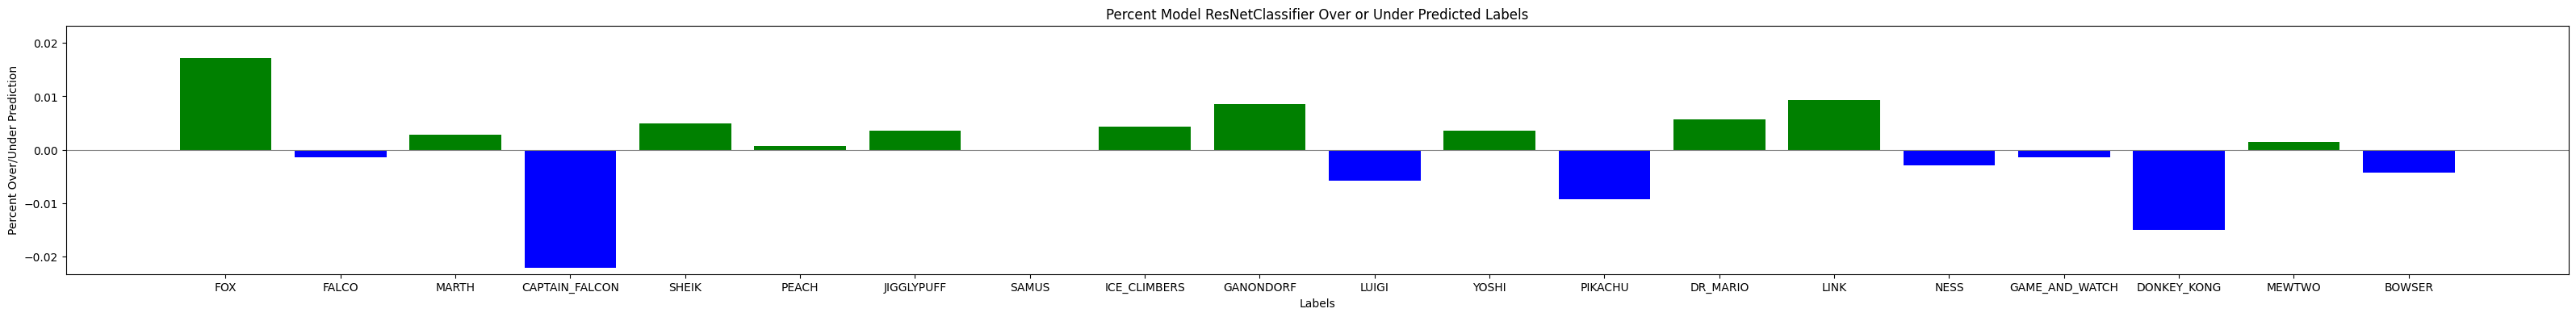

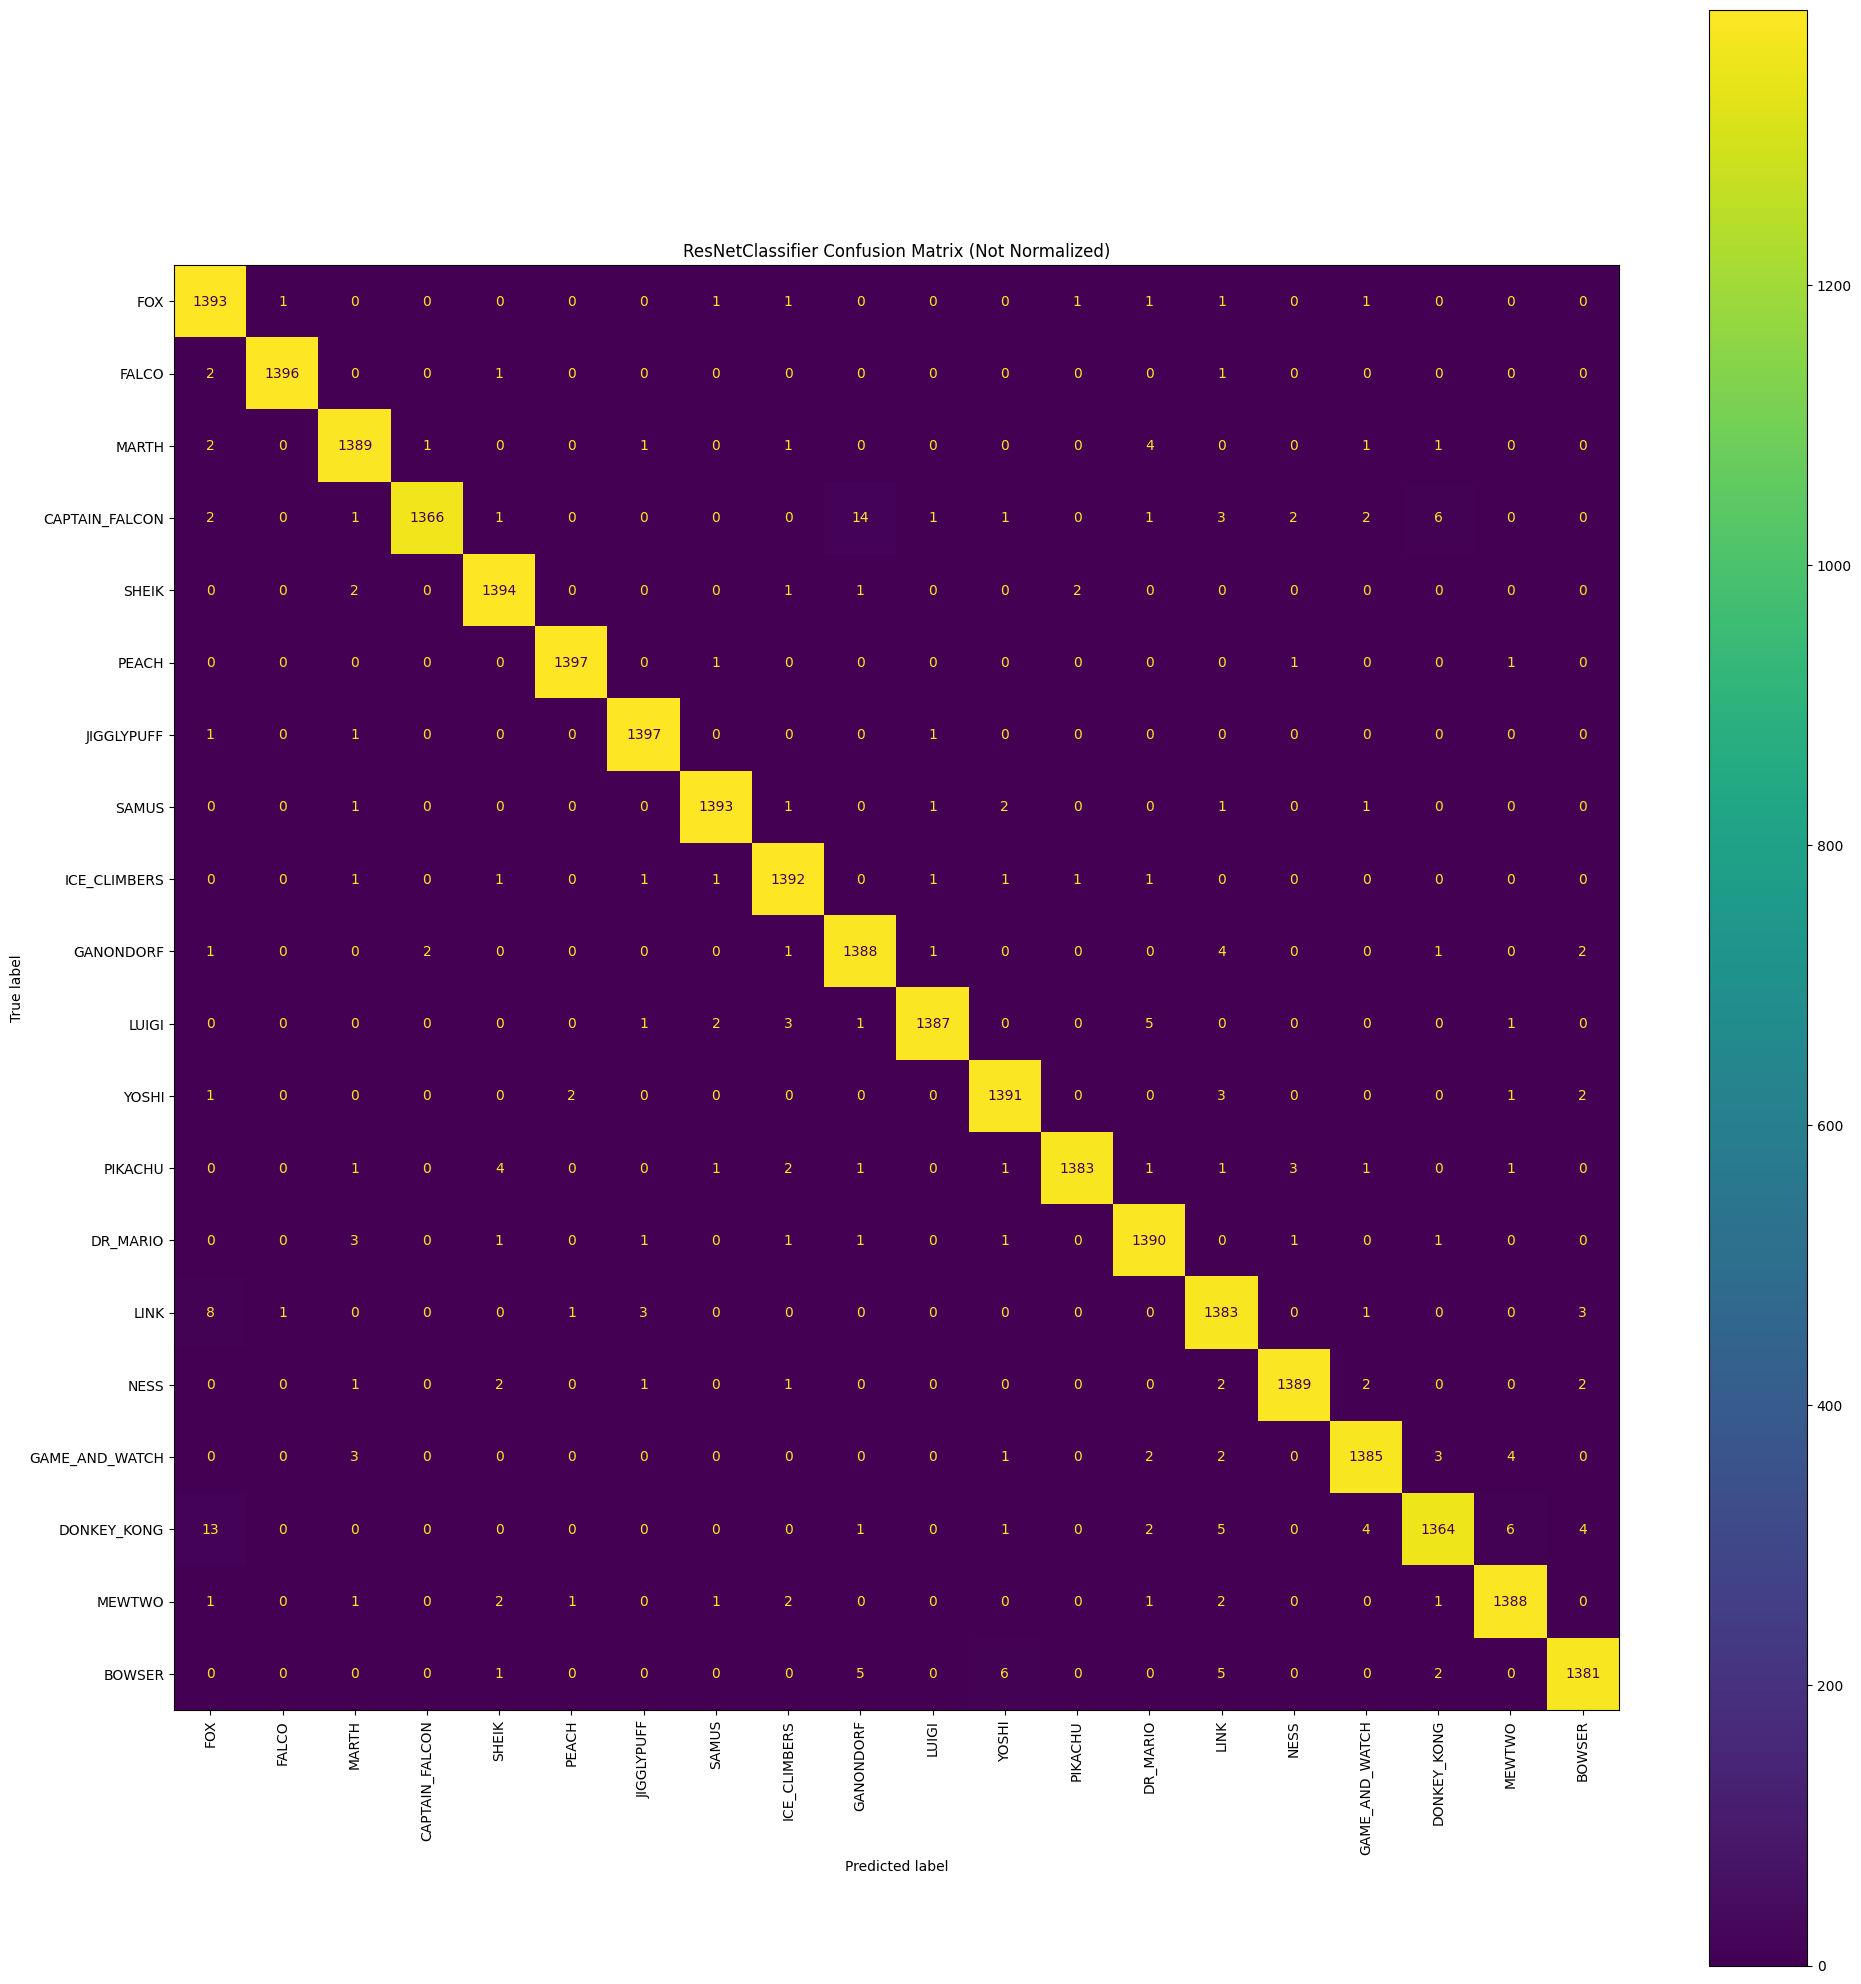

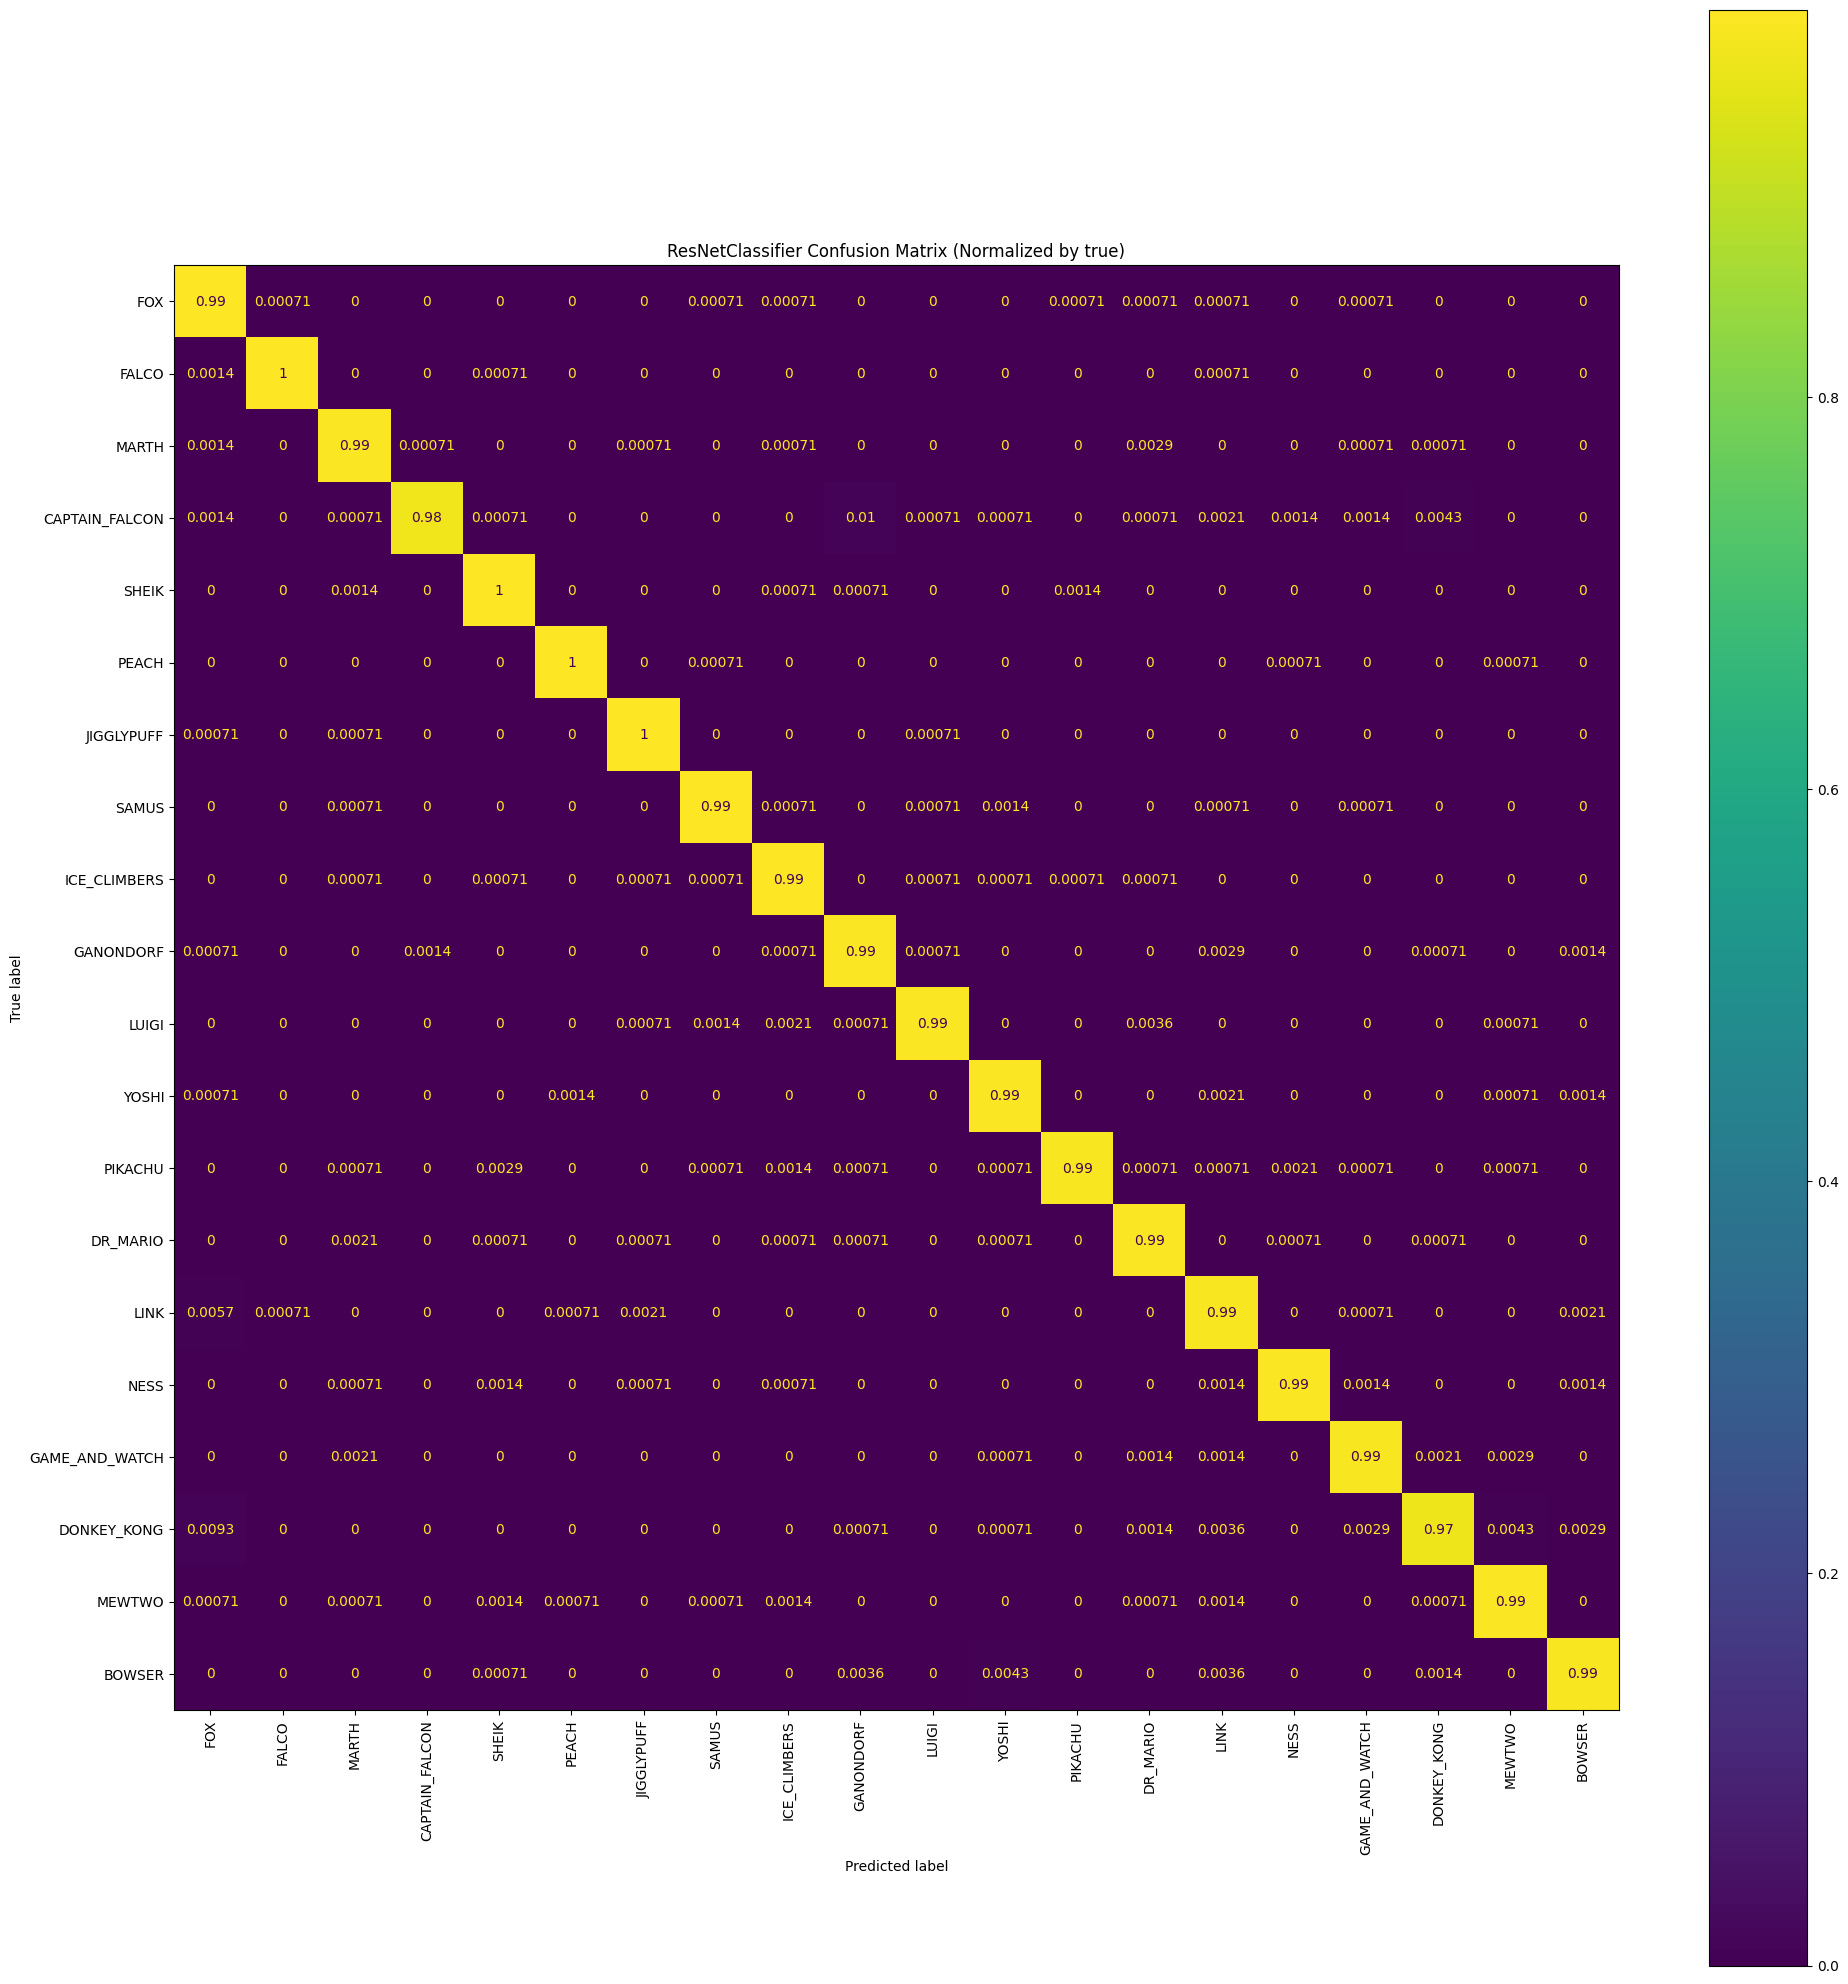

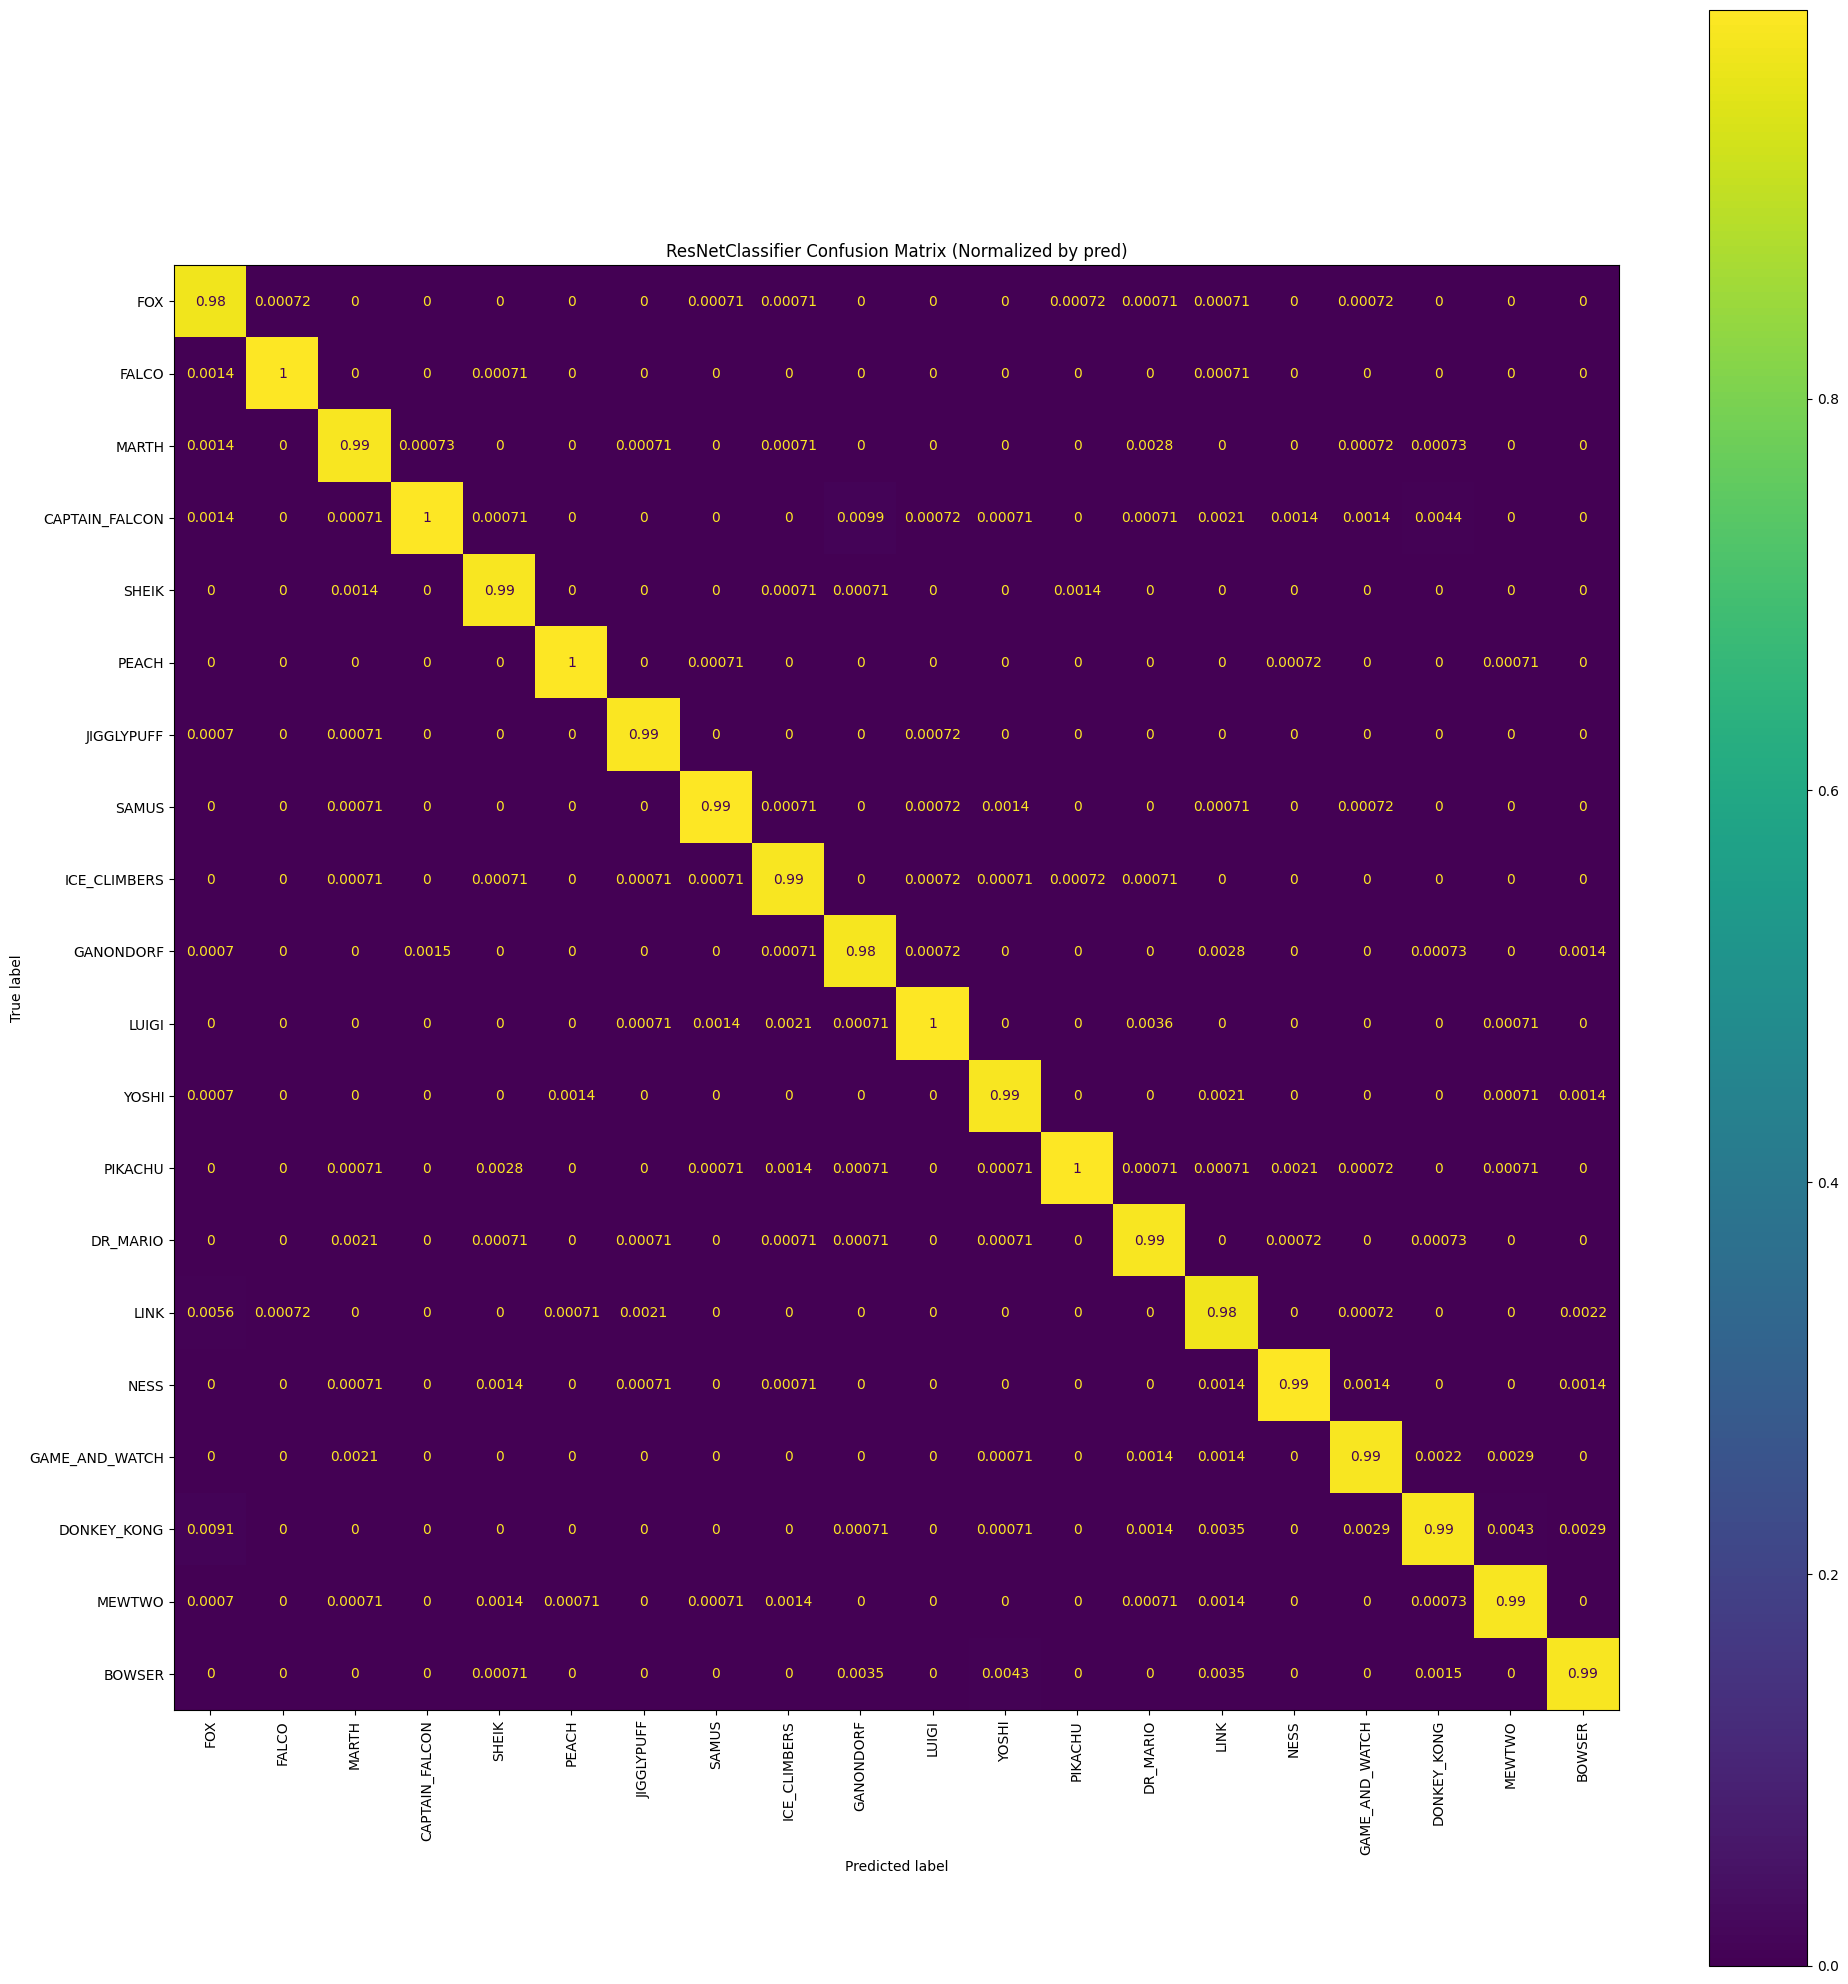

In [12]:
y_pred = resnet_model.predict(X_test)
asses_model(model_name, y_pred, y_test,labels_order)

In [ ]:
batch_size = 16
epochs = 2
model_name = 'InceptionTimeClassifier'

inceptiontime_model = InceptionTimeClassifier(n_epochs=epochs, batch_size=batch_size,  random_state=42, verbose=True, loss='categorical_crossentropy')
inceptiontime_model.fit(X_train, y_train) 
y_pred = inceptiontime_model.predict(X_test) 
asses_model(model_name, y_pred, y_test,labels_order)
tf.compat.v1.reset_default_graph()

In [ ]:
# model_name = 'MiniRocketClassifier'
# rocket_model = RocketClassifier(num_kernels=1000, n_jobs=-1, random_state=42, rocket_transform = 'minirocket') 
# rocket_model.fit(X_train, y_train) 
# y_pred = rocket_model.predict(X_test) 
# asses_model(model_name, y_pred, y_test,labels_order)

In [ ]:
epochs = 2  # You might want to increase this gradually to find the sweet spot
batch_size = 32  # A smaller batch size than the default to help with generalization
kernel_size = 20  # Smaller than default, assuming it still captures relevant features in your data
n_filters = 16  # Fewer filters to reduce model complexity
depth = 4  # Reduced depth to simplify the model

inceptiontime_model = InceptionTimeClassifier(
    n_epochs=epochs,
    batch_size=batch_size,
    kernel_size=kernel_size,
    n_filters=n_filters,
    use_residual=True,  # Keep using residual connections, but this can be toggled for experimentation
    use_bottleneck=True,  # Keep the bottleneck, but consider adjusting the size if overfitting persists
    bottleneck_size=32,  # You might want to reduce this if the model is still overfitting
    depth=depth,
    random_state=42,
    verbose=True,
    loss='categorical_crossentropy'
)

inceptiontime_model.fit(X_train, y_train) 
y_pred = inceptiontime_model.predict(X_test) 
asses_model(model_name, y_pred, y_test, labels_order)
tf.compat.v1.reset_default_graph()
